In [2]:
import pandas as pd
import numpy as np
from sklearn.impute import MissingIndicator
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_recall_curve,precision_recall_fscore_support,classification_report,precision_score,recall_score,f1_score,roc_curve,auc,cohen_kappa_score
import re
import string
from itertools import combinations
from pandas import value_counts
from datetime import datetime
import math
from textblob import TextBlob as tb
from sklearn.feature_extraction.text import TfidfVectorizer
import lightgbm as lgb
from imblearn.over_sampling import SMOTE

In [4]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from lightgbm import LGBMRegressor,LGBMClassifier,LGBMModel
import lightgbm as lgb

In [5]:
nlpdata=pd.read_csv('./NLPwithbinarizer.csv')

In [6]:
data=pd.read_csv('./level2nd3data.csv')

In [6]:
del data['Unnamed: 0']
del data['Unnamed: 0.1']

In [7]:
data=data.set_index(data['report_id'])

In [11]:
sp=lambda x : x.split('|')
sp2=lambda x : x.split(':')
com=lambda k,b:[a for a in k if a not in b]

In [12]:
level2=[]
level3=[]
l2initializer=[]
l3initializer=[]
initializer=[]
test=[' A**** P**** S**** ',' P**** L**** ',' P**** R**** ']
for i in range(len(nlpdata)):
    temp=data.loc[nlpdata['report_id'][i]]
    if type(temp['HFACS'])!=float:
        if isinstance(temp,pd.core.frame.DataFrame):
            templevel2=[]
            templevel3=[]
            for j in range(len(temp)):
                split=sp(temp['HFACS'][j])
                if len(split)==2:
                    if split[1] not in templevel2:
                        templevel2.append(split[1].replace(" ","").lower())
                    if split[1] not in l2initializer:
                        l2initializer.append(split[1].replace(" ","").lower())
                    if split[1] not in initializer:
                        initializer.append(split[1].replace(" ","").lower())
                if len(split)==3:
                    if split[1] not in templevel2:
                        templevel2.append(split[1].replace(" ","").lower())
                    if split[2] not in templevel3 and split[2] not in test:
                        templevel3.append(split[2].replace(" ","").lower())
                    if split[1] not in l2initializer:
                        l2initializer.append(split[1].replace(" ","").lower())
                    if split[2] not in l3initializer and split[2] not in test:
                        l3initializer.append(split[2].replace(" ","").lower())
                    if split[1] not in initializer:
                        initializer.append(split[1].replace(" ","").lower())
                    if split[2] not in initializer and split[2] not in test:
                        initializer.append(split[2].replace(" ","").lower())
        else:
            templevel2=[]
            templevel3=[]
            split=sp(temp['H****'])
            if len(split)==2:
                if split[1] not in templevel2:
                    templevel2.append(split[1].replace(" ","").lower())
                if split[1] not in l2initializer:
                    l2initializer.append(split[1].replace(" ","").lower())
                if split[1] not in initializer:
                    initializer.append(split[1].replace(" ","").lower())
            if len(split)==3:
                if split[1] not in templevel2:
                    templevel2.append(split[1].replace(" ","").lower())
                if split[2] not in templevel3 and split[2] not in test:
                    templevel3.append(split[2].replace(" ","").lower())
                if split[1] not in l2initializer:
                    l2initializer.append(split[1].replace(" ","").lower())
                if split[2] not in l3initializer and split[2] not in test:
                    l3initializer.append(split[2].replace(" ","").lower())
                if split[1] not in initializer:
                    initializer.append(split[1].replace(" ","").lower())
                if split[2] not in initializer and split[2] not in test:
                    initializer.append(split[2].replace(" ","").lower())
    else:
        templevel2=[]
        templevel3=[]
    level2.append(templevel2)
    level3.append(templevel3)

In [13]:
l2initializer=set(l2initializer)
l3initializer=set(l3initializer)
initializer=set(initializer)

In [15]:
for i in initializer:
    exec("{}".format(str(i))+"=[]")

In [16]:
for i in range(len(nlpdata)):
    if len(level2[i])==0:
        for j in l2initializer:
            eval('{}'.format(j)+'.append(0)')
    else:
        templ2=[]
        for k in level2[i]:
            if k not in templ2:
                eval('{}'.format(k)+'.append(1)')
                templ2.append(k)
        subractingsubsets=set(l2initializer)-set(templ2)
        for l in subractingsubsets:
            eval('{}'.format(l)+'.append(0)')
    if len(level3[i])==0:
        for j in l3initializer:
            eval('{}'.format(j)+'.append(0)')
    else:
        templ3=[]
        for k in level3[i]:
            if k not in templ3:
                eval('{}'.format(k)+'.append(1)')
                templ3.append(k)
        subractingsubsets=set(l3initializer)-set(templ3)
        for l in subractingsubsets:
            eval('{}'.format(l)+'.append(0)')

In [18]:
for i in l2initializer:
    nlpdata[i]=eval('{}'.format(i))
for i in l3initializer:
    nlpdata[i]=eval('{}'.format(i))

In [20]:
coll=nlpdata.columns

In [22]:
def lgbmodel(x,y):
    x,xx,y,yy=train_test_split(x,y,test_size=0.2)
    tempmodel=lgb.LGBMClassifier(objective='binary',learning_rate=0.05,num_leaves=35)
    tempmodel.fit(X=x,y=y,eval_metric='binary_logloss')
    predicted=tempmodel.predict(xx)
    jj=0
    for i in range(len(list(predicted))):
        if (list(predicted)[i]==list(yy)[i]):
            jj+=1
    acc=float(jj)/len(predicted)
    return(tempmodel,acc)

In [23]:
def RFmodel(x,y):
    x,xx,y,yy=train_test_split(x,y,test_size=0.2)
    tempmodel=RandomForestClassifier(n_estimators= 25,random_state= 10)
    tempmodel.fit(X=x,y=y)
    predicted=tempmodel.predict(xx)
    jj=0
    for i in range(len(list(predicted))):
        if (list(predicted)[i]==list(yy)[i]):
            jj+=1
    acc=float(jj)/len(predicted)
    return(tempmodel,acc)

In [24]:
def NBmodel(x,y):
    x,xx,y,yy=train_test_split(x,y,test_size=0.2)
    tempmodel=GaussianNB()
    tempmodel.fit(X=x,y=y)
    predicted=tempmodel.predict(xx)
    jj=0
    for i in range(len(list(predicted))):
        if (list(predicted)[i]==list(yy)[i]):
            jj+=1
    acc=float(jj)/len(predicted)
    return(tempmodel,acc)

In [25]:
def missing(x):
    temp=[]
    for i in range(len(x)):
        if pd.isna(x[i]):
            temp.append(True)
        else:
            temp.append(False)
    return(temp)

In [26]:
onehot_object=[]
labelencoder_object=[]

In [27]:
def onehot(y):
    labencoder=LabelEncoder()
    encoder=OneHotEncoder(sparse=False)
    inter=labencoder.fit_transform(y)
    encoder.fit(inter.reshape(-1,1))
    result=encoder.fit_transform(inter.reshape(-1,1))
    result=np.ndarray.tolist(result)
    onehot_object.append(encoder)
    labelencoder_object.append(labencoder)
    onehot.counter+=1
    return result
onehot.counter=0

In [28]:
def fillmissing(z,typ):
    mis=missing(z)
    temp=[]
    for i in range(len(mis)):
        if mis[i]==False:
            temp.append(z[i])
    if typ=='mean':
        mean=reduce(lambda x, y: int(x) + int(y), temp) / len(temp)
        for i in range(len(mis)):
            if mis[i]==True:
                z[i]=int(mean)
    if typ=='mode':
        mode=max(set(temp), key=temp.count)
        for i in range(len(mis)):
            if mis[i]==True:
                z[i]=mode
    return(z)

In [29]:
tfidfvec=TfidfVectorizer()

In [30]:
features=[]
features.append('date')
for i in list(set(fillmissing(data['S****'],'mode'))):
    features.append('S****_'+str(i))
for i in list(set(fillmissing(data['WO****'],'mode'))):
    features.append('WO*****_'+str(i))
features.append('H*****')
features.append('HO*****')
for i in list(set(fillmissing(data['A*****'],'mode'))):
    features.append('A*****'+str(i))
for i in list(set(fillmissing(data['I*****'],'mode'))):
    features.append('I*****'+str(i))
for i in list(set(fillmissing(data['a*****'],'mode'))):
    features.append('a*****'+str(i))
for i in list(set(fillmissing(data['f*****'],'mode'))):
    features.append('f*****'+str(i))

In [31]:
def preprocessing(data):
    data=data.reset_index()
    del data['index']
    del data['H*****']
    dict={}
    for i in range(9+4):
        dict['col{0}'.format(i+1)]=[]
    for i in range(len(data)):
        if pd.isna(data['date'][i]):
            j=0
        else:
            datestripped=datetime.strptime(data['date'][i],'%Y-%m-%d')
            date=str(datestripped.year)+'-1-1'
            new_year = datetime.strptime(date,'%Y-%m-%d')
            data['date'][i]=(datestripped-new_year).days+1
    dict['col0']=list(fillmissing(data['date'],'mean'))
    dict['col1']=list(onehot(fillmissing(data['S*****'],'mode')))
    dict['col2']=list(onehot(fillmissing(data['W*****'],'mode')))
    workingovertime=fillmissing(data['W*****'],'mode')
    for i in range(len(data)):
        if workingovertime[i]=='No':
            data['H*****'][i]=0
        else:
            if not pd.isna(data['H*****'][i]):
                splited=str(data['H*****'][i]).split(' ')
                for j in range(len(splited)):
                    try:
                        if type(int(splited[j]))==int:
                            data['H*****'][i]=int(splited[j])
                    except:
                        k=0
            else:
                data['H*****'][i]=0
    dict['col3']=list(data['H*****'])
    for i in range(len(data)):
        if pd.isna(data['H*****'][i]):
            zz=0
        else:
            splited=str(data['H*****'][i]).split(' ')
            for j in range(len(splited)):
                try:
                    if type(int(splited[j]))==int:
                        data['H*****'][i]=int(splited[j])
                except:
                    zz=0
    dict['col4']=list(fillmissing(data['H*****'],'mean'))
    forref=set(data['A*****'])
    for i in range(len(data)):
        if pd.isna(data['A*****'][i]):
            zz=0
        else:
            splited=str(data['A*****'][i]).split('.')
            for j in range(len(splited)):
                try:
                    if type(int(splited[j]))==int:
                        data['A*****'][i]=int(splited[j])
                except:
                    zz=0
    dict['col5']=list(onehot(fillmissing(data['A*****'],'mode')))
    dict['col6']=list(onehot(fillmissing(data['I*****'],'mode')))
    dict['col7']=list(onehot(fillmissing(data['a*****'],'mode')))
    dict['col8']=list(onehot(fillmissing(data['f*****'],'mode')))
    check=lambda x: missing(x)
    columns=['issue','nar*****','Sug*****','Com*****','SM*****']
    dict_tfidf={}
    dict_topwords={'issue':[],'nar*****':[],'Sug*****':[],'Com*****':[],'SM*****':[]}
    for k in columns:
        dict_tfidf['{0}'.format(k)]=[]
        c=check(data[k])
        temp=[]
        for i in range(len(data[k])):
            if not c[i]:
                temp.append(data[k][i])
            else:
                temp.append('not available')
        vector=tfidfvec.fit_transform(temp)
        words=tfidfvec.get_feature_names()
        array=vector.toarray()
        index=np.argsort(tfidfvec.idf_)[::-1]
        top_features = [words[i] for i in index[:5000]]
        for i in top_features:
            features.append(''+str(k)+'_'+str(i))
        temp_words=[words[i] for i in index[:10]]
        dict_topwords[k].append(temp_words)
        top_features_index=[i for i in index[:5000]]
        for i in range(len(array)):
            temp=[]
            for j in top_features_index:
                temp.append(array[i][j])
            dict_tfidf['{0}'.format(k)].append(temp)
    dict_term_count={}
    for i in columns:
        dict_term_count[i]=''
        for j in range(len(data[i])):
            dict_term_count[i]=str(dict_term_count[i])+str(data[i][j])
    dictofdict={}
    frequency = {}
    for i in columns:
        temmp=''
        for j in range(len(dict_topwords[i])):
            temmp=str(temmp)+str(dict_topwords[i][0][j])
        document_text = dict_term_count[i]
        text_string = temmp.lower()
        match_pattern = re.findall(r'\b[a-z]{3,15}\b', text_string)

        for word in match_pattern:
            count = frequency.get(word,0)
            frequency[word] = count + 1

        frequency_list = frequency.keys()
        temp=[]
        for words in frequency_list:
             temp.append([words, frequency[words]])
        dictofdict[i]=temp
    for i in range(len(columns)):
        dict['col{0}'.format(9+i)]=dict_tfidf['{0}'.format(columns[i])]
    X=[]
    for i in range(len(data)):
        X.append([])
    for k in range(len(dict)):
        for i in range(len(data)):
            if type(dict['col{0}'.format(k)][0])==list:                
                for j in range(len(dict['col{0}'.format(k)][0])):
                    X[i].append(abs(dict['col{0}'.format(k)][i][j]))
            else:
                X[i].append(abs(dict['col{0}'.format(k)][i]))
    x_value=np.asarray(X)
    return(x_value)

In [32]:
preprocessedX=preprocessing(nlpdata)

In [33]:
def feature_importance(model):
    importances=model.feature_importances_
    std = np.std([tree.feature_importances_ for tree in model.estimators_],axis=0)
    indices = np.argsort(importances)[::-1]
    for f in range(preprocessedX.shape[1]):
        print("%d. feature %s (%f)" % (f + 1, features[indices[f]], importances[indices[f]]))

In [35]:
UA_X,PFUA_X,OI_X=preprocessedX[nlpdata['Uns*****']==1],preprocessedX[nlpdata['Pre*****']==1],preprocessedX[nlpdata['Or*****']==1]

In [36]:
OI_OC_X,OI_OP_X,OI_RM_X=preprocessedX[nlpdata['o*****']==1],preprocessedX[nlpdata['op*****']==1],preprocessedX[nlpdata['re*****']==1]


In [37]:
PFUA_AMS_X,PFUA_ML_X,PFUA_PE_X,PFUA_TE_X,PFUA_CC_X=preprocessedX[nlpdata['ad*****']==1],preprocessedX[nlpdata['me*****']==1],preprocessedX[nlpdata['physicalenvironment']==1],preprocessedX[nlpdata['technologicalenvironment']==1],preprocessedX[nlpdata['coordinationandcommunication']==1]

In [38]:
UA_DE_X,UA_PE_X,UA_SBE_X,UA_EV_X,UA_RV_X=preprocessedX[nlpdata['de*****']==1],preprocessedX[nlpdata['pe*****']==1],preprocessedX[nlpdata['sk*****']==1],preprocessedX[nlpdata['ex*****']==1],preprocessedX[nlpdata['ro*****']==1]


In [39]:
UA_Y,PFUA_Y,OI_Y=nlpdata['U*****'],nlpdata['Pr*****'],nlpdata['Or*****']

In [40]:
OI_OC_Y,OI_OP_Y,OI_RM_Y=nlpdata['op*****'][nlpdata['O*****']==1],nlpdata['o*****'][nlpdata['O*****']==1],nlpdata['re*****'][nlpdata['Or*****']==1]

In [41]:
PFUA_AMS_Y,PFUA_ML_Y,PFUA_PE_Y,PFUA_TE_Y,PFUA_CC_Y=nlpdata['a*****'][nlpdata['P*****']==1],nlpdata['m*****'][nlpdata['P*****']==1],nlpdata['p*****'][nlpdata['P*****']==1],nlpdata['t*****'][nlpdata['P*****']==1],nlpdata['c*****'][nlpdata['P*****']==1]


In [42]:
UA_DE_Y,UA_PE_Y,UA_SBE_Y,UA_EV_Y,UA_RV_Y=nlpdata['d*****'][nlpdata['U*****']==1],nlpdata['p*****'][nlpdata['U*****']==1],nlpdata['s*****'][nlpdata['U*****']==1],nlpdata['e*****'][nlpdata['U*****']==1],nlpdata['r*****'][nlpdata['U*****']==1]


In [43]:
def resample(x,y):
    resampling=SMOTE(k_neighbors=5)
    xx,yy=resampling.fit_sample(x,y)
    return(xx,yy)

Unsafe Acts

In [44]:
UA_Y.value_counts().plot(kind='bar')

In [45]:
UA_X_resampled,UA_Y_resampled=resample(x=preprocessedX,y=UA_Y)

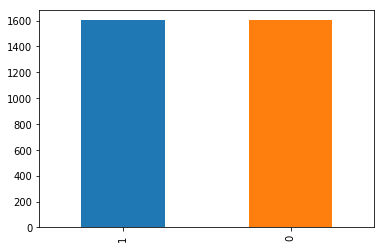

In [46]:
pd.DataFrame(data=UA_Y_resampled)[0].value_counts().plot(kind='bar')

In [47]:
lgbmodel(UA_X_resampled,UA_Y_resampled)

(LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
         importance_type='split', learning_rate=0.05, max_depth=-1,
         min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
         n_estimators=100, n_jobs=-1, num_leaves=35, objective='binary',
         random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
         subsample=1.0, subsample_for_bin=200000, subsample_freq=0),
 0.7956318252730109)

In [48]:
NBmodel(UA_X_resampled,UA_Y_resampled)

(GaussianNB(priors=None, var_smoothing=1e-09), 0.733229329173167)

In [49]:
UA_model,UA_acc=RFmodel(UA_X_resampled,UA_Y_resampled)

In [50]:
UA_acc

0.8096723868954758

Precondition for unsafe acts

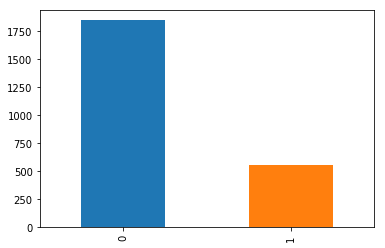

In [52]:
PFUA_Y.value_counts().plot(kind='bar')

In [53]:
PFUA_X_resampled,PFUA_Y_resampled=resample(x=preprocessedX,y=PFUA_Y)

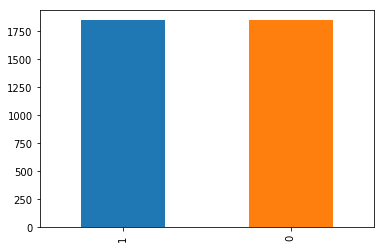

In [54]:
pd.DataFrame(data=PFUA_Y_resampled)[0].value_counts().plot(kind='bar')

In [55]:
lgbmodel(PFUA_X_resampled,PFUA_Y_resampled)

(LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
         importance_type='split', learning_rate=0.05, max_depth=-1,
         min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
         n_estimators=100, n_jobs=-1, num_leaves=35, objective='binary',
         random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
         subsample=1.0, subsample_for_bin=200000, subsample_freq=0),
 0.8509485094850948)

In [56]:
NBmodel(PFUA_X_resampled,PFUA_Y_resampled)

(GaussianNB(priors=None, var_smoothing=1e-09), 0.7737127371273713)

In [57]:
PFUA_model,PFUA_acc=RFmodel(PFUA_X_resampled,PFUA_Y_resampled)

In [58]:
PFUA_acc

0.9051490514905149

organizational influence

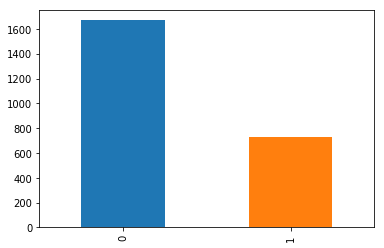

In [60]:
OI_Y.value_counts().plot(kind='bar')

In [61]:
OI_X_resampled,OI_Y_resampled=resample(x=preprocessedX,y=OI_Y)

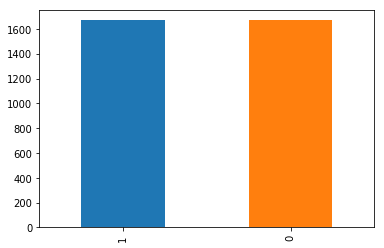

In [62]:
pd.DataFrame(data=OI_Y_resampled)[0].value_counts().plot(kind='bar')

In [63]:
lgbmodel(OI_X_resampled,OI_Y_resampled)

(LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
         importance_type='split', learning_rate=0.05, max_depth=-1,
         min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
         n_estimators=100, n_jobs=-1, num_leaves=35, objective='binary',
         random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
         subsample=1.0, subsample_for_bin=200000, subsample_freq=0),
 0.8068862275449101)

In [64]:
NBmodel(OI_X_resampled,OI_Y_resampled)

(GaussianNB(priors=None, var_smoothing=1e-09), 0.7260479041916168)

In [65]:
OI_model,OI_acc=RFmodel(OI_X_resampled,OI_Y_resampled)

In [66]:
OI_acc

0.811377245508982

Unsafeacts | Decision error

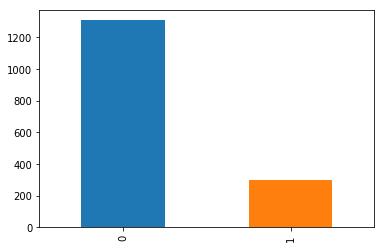

In [68]:
UA_DE_Y.value_counts().plot(kind='bar')

In [69]:
UA_DE_X_resampled,UA_DE_Y_resampled=resample(x=UA_X,y=UA_DE_Y)

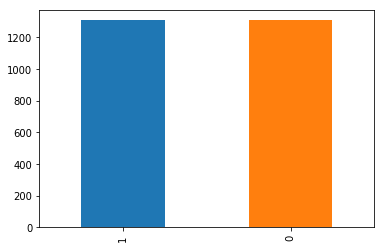

In [70]:
pd.DataFrame(data=UA_DE_Y_resampled)[0].value_counts().plot(kind='bar')

In [71]:
lgbmodel(UA_DE_X_resampled,UA_DE_Y_resampled)

(LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
         importance_type='split', learning_rate=0.05, max_depth=-1,
         min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
         n_estimators=100, n_jobs=-1, num_leaves=35, objective='binary',
         random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
         subsample=1.0, subsample_for_bin=200000, subsample_freq=0),
 0.904397705544933)

In [72]:
NBmodel(UA_DE_X_resampled,UA_DE_Y_resampled)

(GaussianNB(priors=None, var_smoothing=1e-09), 0.8489483747609943)

In [73]:
UA_DE_model,UA_DE_acc=RFmodel(UA_DE_X_resampled,UA_DE_Y_resampled)

In [74]:
UA_DE_acc

0.904397705544933

Unsafeacts | Perceptual error

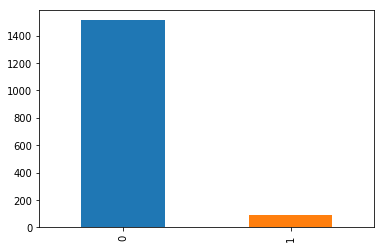

In [76]:
UA_PE_Y.value_counts().plot(kind='bar')

In [77]:
UA_PE_X_resampled,UA_PE_Y_resampled=resample(x=UA_X,y=UA_PE_Y)

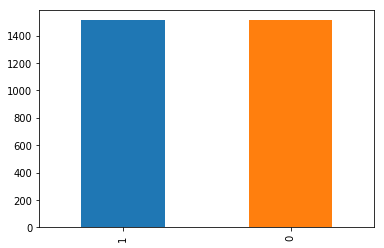

In [78]:
pd.DataFrame(data=UA_PE_Y_resampled)[0].value_counts().plot(kind='bar')

In [79]:
lgbmodel(UA_PE_X_resampled,UA_PE_Y_resampled)

(LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
         importance_type='split', learning_rate=0.05, max_depth=-1,
         min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
         n_estimators=100, n_jobs=-1, num_leaves=35, objective='binary',
         random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
         subsample=1.0, subsample_for_bin=200000, subsample_freq=0),
 0.9702479338842975)

In [80]:
UA_PE_model,UA_PE_acc=NBmodel(UA_PE_X_resampled,UA_PE_Y_resampled)

In [81]:
UA_PE_acc

0.9272727272727272

In [82]:
RFmodel(UA_PE_X_resampled,UA_PE_Y_resampled)

(RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=None, max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=25, n_jobs=None,
             oob_score=False, random_state=10, verbose=0, warm_start=False),
 0.9950413223140496)

Unsafeacts | Skill based error

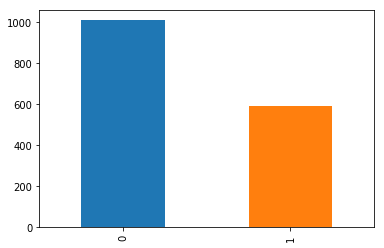

In [83]:
UA_SBE_Y.value_counts().plot(kind='bar')

In [84]:
UA_SBE_X_resampled,UA_SBE_Y_resampled=resample(x=UA_X,y=UA_SBE_Y)

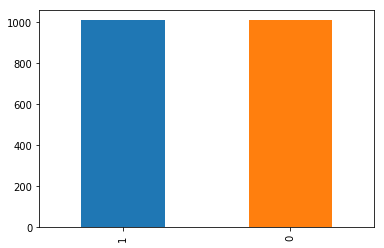

In [85]:
pd.DataFrame(data=UA_SBE_Y_resampled)[0].value_counts().plot(kind='bar')

In [86]:
UA_SBE_model,UA_SBE_acc=lgbmodel(UA_SBE_X_resampled,UA_SBE_Y_resampled)

In [87]:
NBmodel(UA_SBE_X_resampled,UA_SBE_Y_resampled)

(GaussianNB(priors=None, var_smoothing=1e-09), 0.7128712871287128)

In [88]:
RFmodel(UA_SBE_X_resampled,UA_SBE_Y_resampled)

(RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=None, max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=25, n_jobs=None,
             oob_score=False, random_state=10, verbose=0, warm_start=False),
 0.7252475247524752)

Unsafeacts | Exceptional Violation

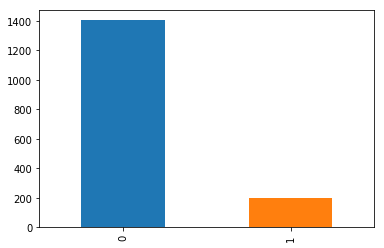

In [89]:
UA_EV_Y.value_counts().plot(kind='bar')

In [90]:
UA_EV_X_resampled,UA_EV_Y_resampled=resample(x=UA_X,y=UA_EV_Y)

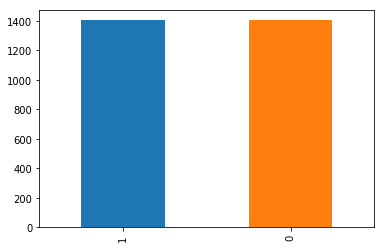

In [91]:
pd.DataFrame(data=UA_EV_Y_resampled)[0].value_counts().plot(kind='bar')

In [92]:
lgbmodel(UA_EV_X_resampled,UA_EV_Y_resampled)

(LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
         importance_type='split', learning_rate=0.05, max_depth=-1,
         min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
         n_estimators=100, n_jobs=-1, num_leaves=35, objective='binary',
         random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
         subsample=1.0, subsample_for_bin=200000, subsample_freq=0),
 0.9217081850533808)

In [93]:
NBmodel(UA_EV_X_resampled,UA_EV_Y_resampled)

(GaussianNB(priors=None, var_smoothing=1e-09), 0.8416370106761566)

In [94]:
UA_EV_model,UA_EV_acc=RFmodel(UA_EV_X_resampled,UA_EV_Y_resampled)

Unsafeacts | Routine Violation

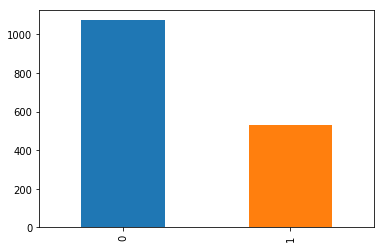

In [95]:
UA_RV_Y.value_counts().plot(kind='bar')

In [96]:
UA_RV_X_resampled,UA_RV_Y_resampled=resample(x=UA_X,y=UA_RV_Y)

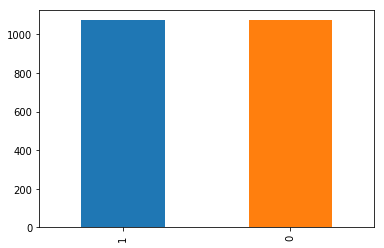

In [97]:
pd.DataFrame(data=UA_RV_Y_resampled)[0].value_counts().plot(kind='bar')

In [98]:
lgbmodel(UA_RV_X_resampled,UA_RV_Y_resampled)

(LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
         importance_type='split', learning_rate=0.05, max_depth=-1,
         min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
         n_estimators=100, n_jobs=-1, num_leaves=35, objective='binary',
         random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
         subsample=1.0, subsample_for_bin=200000, subsample_freq=0),
 0.7348837209302326)

In [99]:
NBmodel(UA_RV_X_resampled,UA_RV_Y_resampled)

(GaussianNB(priors=None, var_smoothing=1e-09), 0.7232558139534884)

In [100]:
UA_RV_model,UA_RV_acc=RFmodel(UA_RV_X_resampled,UA_RV_Y_resampled)

Organizational influence | Operational Climate

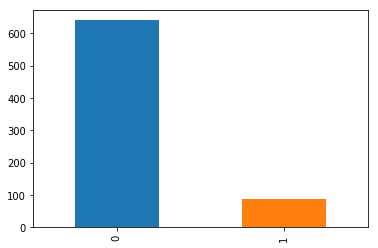

In [101]:
OI_OC_Y.value_counts().plot(kind='bar')

In [102]:
OI_OC_X_resampled,OI_OC_Y_resampled=resample(x=OI_X,y=OI_OC_Y)

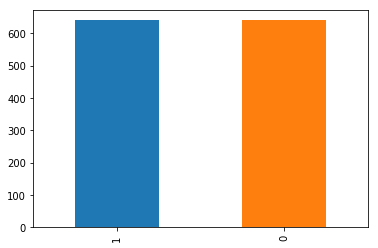

In [103]:
pd.DataFrame(data=OI_OC_Y_resampled)[0].value_counts().plot(kind='bar')

In [104]:
lgbmodel(OI_OC_X_resampled,OI_OC_Y_resampled)

(LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
         importance_type='split', learning_rate=0.05, max_depth=-1,
         min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
         n_estimators=100, n_jobs=-1, num_leaves=35, objective='binary',
         random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
         subsample=1.0, subsample_for_bin=200000, subsample_freq=0),
 0.93359375)

In [105]:
NBmodel(OI_OC_X_resampled,OI_OC_Y_resampled)

(GaussianNB(priors=None, var_smoothing=1e-09), 0.9375)

In [106]:
OI_OC_model,OI_OC_acc=RFmodel(OI_OC_X_resampled,OI_OC_Y_resampled)

Organizational influence | Operational process

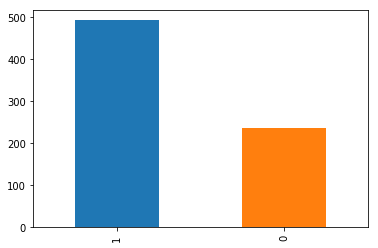

In [107]:
OI_OP_Y.value_counts().plot(kind='bar')

In [108]:
OI_OP_X_resampled,OI_OP_Y_resampled=resample(x=OI_X,y=OI_OP_Y)

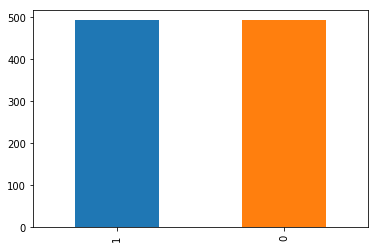

In [109]:
pd.DataFrame(data=OI_OP_Y_resampled)[0].value_counts().plot(kind='bar')

In [110]:
lgbmodel(OI_OP_X_resampled,OI_OP_Y_resampled)

(LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
         importance_type='split', learning_rate=0.05, max_depth=-1,
         min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
         n_estimators=100, n_jobs=-1, num_leaves=35, objective='binary',
         random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
         subsample=1.0, subsample_for_bin=200000, subsample_freq=0),
 0.803030303030303)

In [111]:
OI_OP_model,OI_OP_acc=NBmodel(OI_OP_X_resampled,OI_OP_Y_resampled)

In [112]:
RFmodel(OI_OP_X_resampled,OI_OP_Y_resampled)

(RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=None, max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=25, n_jobs=None,
             oob_score=False, random_state=10, verbose=0, warm_start=False),
 0.8282828282828283)

Organizational Influence | Resource Management

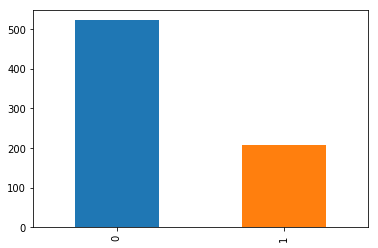

In [113]:
OI_RM_Y.value_counts().plot(kind='bar')

In [114]:
OI_RM_X_resampled,OI_RM_Y_resampled=resample(x=OI_X,y=OI_RM_Y)

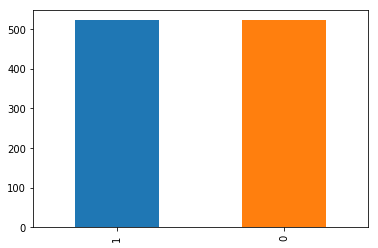

In [115]:
pd.DataFrame(data=OI_RM_Y_resampled)[0].value_counts().plot(kind='bar')

In [116]:
lgbmodel(OI_RM_X_resampled,OI_RM_Y_resampled)

(LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
         importance_type='split', learning_rate=0.05, max_depth=-1,
         min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
         n_estimators=100, n_jobs=-1, num_leaves=35, objective='binary',
         random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
         subsample=1.0, subsample_for_bin=200000, subsample_freq=0),
 0.8660287081339713)

In [117]:
NBmodel(OI_RM_X_resampled,OI_RM_Y_resampled)

(GaussianNB(priors=None, var_smoothing=1e-09), 0.8421052631578947)

In [118]:
OI_RM_model,OI_RM_acc=RFmodel(OI_RM_X_resampled,OI_RM_Y_resampled)

Precondition for unsafe acts | Adverse Mental State

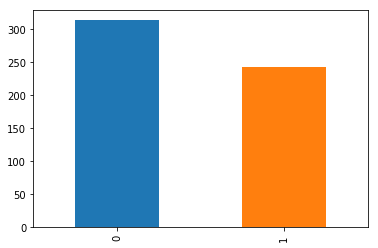

In [119]:
PFUA_AMS_Y.value_counts().plot(kind='bar')

In [120]:
PFUA_AMS_X_resampled,PFUA_AMS_Y_resampled=resample(x=PFUA_X,y=PFUA_AMS_Y)

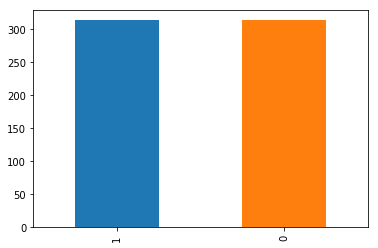

In [121]:
pd.DataFrame(data=PFUA_AMS_Y_resampled)[0].value_counts().plot(kind='bar')

In [122]:
PFUA_AMS_model,PFUA_AMS_acc=lgbmodel(PFUA_AMS_X_resampled,PFUA_AMS_Y_resampled)

In [123]:
NBmodel(PFUA_AMS_X_resampled,PFUA_AMS_Y_resampled)

(GaussianNB(priors=None, var_smoothing=1e-09), 0.7142857142857143)

In [124]:
RFmodel(PFUA_AMS_X_resampled,PFUA_AMS_Y_resampled)

(RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=None, max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=25, n_jobs=None,
             oob_score=False, random_state=10, verbose=0, warm_start=False),
 0.6984126984126984)

Precondition for unsafe acts | Mental Limitations

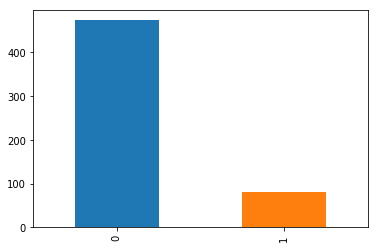

In [125]:
PFUA_ML_Y.value_counts().plot(kind='bar')

In [126]:
PFUA_ML_X_resampled,PFUA_ML_Y_resampled=resample(x=PFUA_X,y=PFUA_ML_Y)

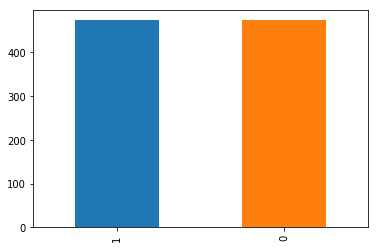

In [127]:
pd.DataFrame(data=PFUA_ML_Y_resampled)[0].value_counts().plot(kind='bar')

In [128]:
lgbmodel(PFUA_ML_X_resampled,PFUA_ML_Y_resampled)

(LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
         importance_type='split', learning_rate=0.05, max_depth=-1,
         min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
         n_estimators=100, n_jobs=-1, num_leaves=35, objective='binary',
         random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
         subsample=1.0, subsample_for_bin=200000, subsample_freq=0),
 0.9368421052631579)

In [129]:
NBmodel(PFUA_ML_X_resampled,PFUA_ML_Y_resampled)

(GaussianNB(priors=None, var_smoothing=1e-09), 0.9631578947368421)

In [130]:
PFUA_ML_model,PFUA_ML_acc=RFmodel(PFUA_ML_X_resampled,PFUA_ML_Y_resampled)

Precondition for unsafe acts | Physical Environment

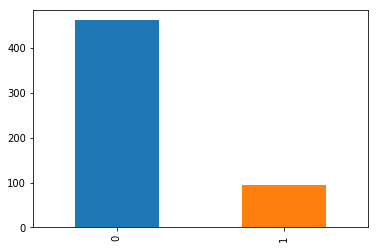

In [131]:
PFUA_PE_Y.value_counts().plot(kind='bar')

In [132]:
PFUA_PE_X_resampled,PFUA_PE_Y_resampled=resample(x=PFUA_X,y=PFUA_PE_Y)

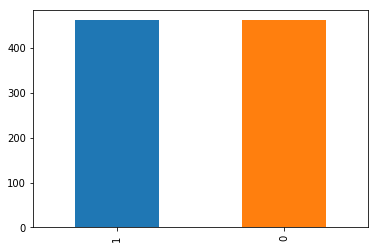

In [133]:
pd.DataFrame(data=PFUA_PE_Y_resampled)[0].value_counts().plot(kind='bar')

In [134]:
PFUA_PE_model,PFUA_PE_acc=lgbmodel(PFUA_PE_X_resampled,PFUA_PE_Y_resampled)

In [135]:
NBmodel(PFUA_PE_X_resampled,PFUA_PE_Y_resampled)

(GaussianNB(priors=None, var_smoothing=1e-09), 0.9027027027027027)

In [136]:
RFmodel(PFUA_PE_X_resampled,PFUA_PE_Y_resampled)

(RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=None, max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=25, n_jobs=None,
             oob_score=False, random_state=10, verbose=0, warm_start=False),
 0.972972972972973)

Precondition for unsafe acts | Technological Environment

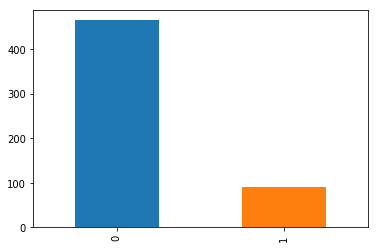

In [137]:
PFUA_TE_Y.value_counts().plot(kind='bar')

In [138]:
PFUA_TE_X_resampled,PFUA_TE_Y_resampled=resample(x=PFUA_X,y=PFUA_TE_Y)

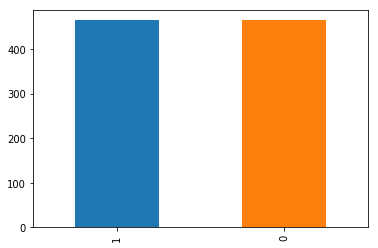

In [139]:
pd.DataFrame(data=PFUA_TE_Y_resampled)[0].value_counts().plot(kind='bar')

In [140]:
lgbmodel(PFUA_TE_X_resampled,PFUA_TE_Y_resampled)

(LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
         importance_type='split', learning_rate=0.05, max_depth=-1,
         min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
         n_estimators=100, n_jobs=-1, num_leaves=35, objective='binary',
         random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
         subsample=1.0, subsample_for_bin=200000, subsample_freq=0),
 0.9139784946236559)

In [141]:
NBmodel(PFUA_TE_X_resampled,PFUA_TE_Y_resampled)

(GaussianNB(priors=None, var_smoothing=1e-09), 0.8924731182795699)

In [142]:
PFUA_TE_model,PFUA_TE_acc=RFmodel(PFUA_TE_X_resampled,PFUA_TE_Y_resampled)

Precondition for unsafe acts | Coordination and communication

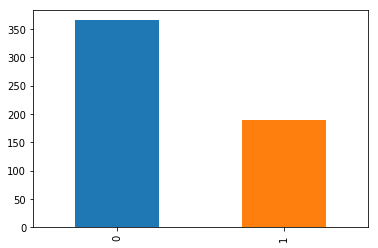

In [143]:
PFUA_CC_Y.value_counts().plot(kind='bar')

In [144]:
PFUA_CC_X_resampled,PFUA_CC_Y_resampled=resample(x=PFUA_X,y=PFUA_CC_Y)

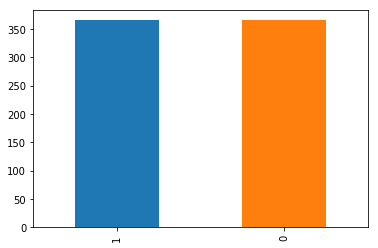

In [145]:
pd.DataFrame(data=PFUA_CC_Y_resampled)[0].value_counts().plot(kind='bar')

In [146]:
lgbmodel(PFUA_CC_X_resampled,PFUA_CC_Y_resampled)

(LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
         importance_type='split', learning_rate=0.05, max_depth=-1,
         min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
         n_estimators=100, n_jobs=-1, num_leaves=35, objective='binary',
         random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
         subsample=1.0, subsample_for_bin=200000, subsample_freq=0),
 0.7191780821917808)

In [147]:
PFUA_CC_model,PFUA_CC_acc=NBmodel(PFUA_CC_X_resampled,PFUA_CC_Y_resampled)

In [148]:
RFmodel(PFUA_CC_X_resampled,PFUA_CC_Y_resampled)

(RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=None, max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=25, n_jobs=None,
             oob_score=False, random_state=10, verbose=0, warm_start=False),
 0.7876712328767124)

<center><font size=10>Important features</font></center>

In [7]:
finallevel=pd.read_csv('./Reports.csv')

In [154]:
listoflist=[]
countcheck=[]
index=[]
for i in range(len(finallevel)):
    if i<len(nlpdata):
        if type(finallevel['H*****'][i])!=float:
            temp=sp(finallevel['H*****'][i].replace(" ",""))
            t=''
            tt=[]
            for j in temp:
                if j!='':
                    try:
                        t=t+sp2(j)[3]+'|'
                        tt.append(sp2(j)[3])
                        countcheck.append(sp2(j)[3])
                    except:
                        t=t
            index.append(i)
            listoflist.append(tt)
        else:
            listoflist.append([])

In [156]:
counts=pd.DataFrame(data=countcheck)[0].value_counts()

In [157]:
COUNTS=pd.DataFrame(data=counts)

In [159]:
classselection=COUNTS.index[COUNTS[0]>30]

In [160]:
classselection=[a.encode('utf-8') for a in classselection]

In [162]:
temp=[]
finalclass={}
for i in classselection:
    if i not in temp:
        temp.append(i)
        t=[]
        for j in listoflist:
            if i in j:
                t.append(1)
            else:
                t.append(0)
    finalclass[i]=t

In [164]:
keys=finalclass.keys()

In [165]:
con=lambda x : ''.join(e for e in x if e.isalnum())

In [166]:
XX=preprocessedX

In [168]:
for k in keys:
    exec("{0}_X_resampled,{0}_Y_resampled=resample(XX,finalclass['{1}'])".format(con(k),k))
    exec("{0}_model,{0}_acc=RFmodel({0}_X_resampled,{0}_Y_resampled)".format(con(k)))
    exec("{0}_acc".format(con(k)))

In [170]:
for k in keys:
    exec("print('{1} -',{0}_acc)".format(con(k),k))

('Failedtofollowtechnical/safetyprocedures -', 0.9845814977973568)
('Lackingtechnicalproceduralknowledge -', 0.9936034115138592)
('Misreading/MisinterpretingPaperwork -', 0.9585308056872038)
('Mindset/preconceivedidea/expectancy -', 0.9978835978835979)
('Procedures/directivesnotfollowed -', 0.935251798561151)
('FailedToFollowTechnical/SafetyProcedures -', 0.9967948717948718)
('Complacency -', 0.9978768577494692)
('Confusion -', 0.9968017057569296)
('Inattention -', 0.990301724137931)
('Aircraftsystemsnotrestoredfollowingmaintenance(e.g.,MELprocedures,gearpins) -', 0.9978700745473909)
('Failedtocomplywithtrainingguidelinesand/orOperatingGuidelinesbyindividualorgroup -', 0.9978880675818373)
('Reversed/OmittedStepInProcedure -', 0.9968085106382979)
('ImproperProcedurePerformed -', 0.9945887445887446)
('Channelizedattention/taskfixation/tunnelvision -', 0.9989429175475687)
('AcceptedUnnecessaryHazard -', 0.9978768577494692)
('FailureToProperlyInspect -', 0.9946638207043756)
('Inadequatetec

<center><font size=10>Model Layout</font></center>

In [8]:
ExcellHFACS=pd.ExcelFile('./H***** Summary.xlsx')

In [172]:
HFACSSummary=pd.read_excel(ExcellHFACS,'Category Codes')

In [173]:
for i in range(len(HFACSSummary)):
    if type(HFACSSummary['Level 2'][i])==float:
        HFACSSummary['Level 2'][i]='Not Available'

In [174]:
HFACSSummary['Level 1']=[a.replace(" ","") for a in HFACSSummary['Level 1']]
HFACSSummary['Level 2']=[a.replace(" ","") for a in HFACSSummary['Level 2']]

In [175]:
dictoffinallevel={}
for k in keys:
    kkk=dictoffinallevel.keys()
    kk=list(HFACSSummary['Level 1'].ix[HFACSSummary['Level 2']==k])[0].encode('utf-8').lower()
    if kk not in kkk:
        dictoffinallevel[kk]={k:['{0}_model'.format(con(k))]}
    else:
        dictoffinallevel[kk][k]=['{0}_model'.format(con(k))]

In [177]:
layer1={'un*****':[UA_model],'p*****':[PFUA_model],'or*****':[OI_model]}
preconditionforunsafeacts={'ad*****':[PFUA_AMS_model],'m*****':[PFUA_ML_model],'p*****':[PFUA_PE_model],'t*****':[PFUA_TE_model],'c*****':[PFUA_CC_model]}
unsafeacts={'d*****':[UA_DE_model],'pe*****':[UA_PE_model],'s*****':[UA_SBE_model],'e*****':[UA_EV_model],'r*****':[UA_RV_model]}
organizationalinfluence={'o*****':[OI_OC_model],'op*****':[OI_OP_model],'r*****':[OI_RM_model]}


In [178]:
for k in layer1.keys():
    exec('{0}_prediction=[]'.format(k))
for k in preconditionforunsafeacts.keys():
    exec('{0}_prediction=[]'.format(k))
for k in unsafeacts.keys():
    exec('{0}_prediction=[]'.format(k))
for k in organizationalinfluence.keys():
    exec('{0}_prediction=[]'.format(k))

In [179]:
for kk in dictoffinallevel.keys():
    for k in dictoffinallevel[kk].keys():
        exec('{0}_prediction=[]'.format(con(k)))

In [180]:
code_level2='''
temp=[]
check=0
for ii in {0}_prediction:
    if ii==1:
        temp.append({1}_prediction[check])
        check+=1
    else:
        temp.append(0)'''
code_level3='''
temp=[]
check=0
for iii in predicted_levels['{0}']:
    if iii==1:
        temp.append(pre[check])
        check+=1
    else:
        temp.append(0)'''

In [181]:
def integratedmodel(data):
    data=np.asarray(data)
    predicted_levels={}
    for i in layer1.keys():
        try:
            exec("{0}_prediction=layer1['{0}'][0].predict(data)".format(i))
        except:
            exec("{0}_prediction=[0]*len(data)".format(i))
        exec("{0}_X=data[np.where(np.asarray({0}_prediction)==1)]".format(i))
        exec("predicted_levels['{0}']={0}_prediction".format(i))
        print(i)
        for j in eval("{0}".format(i)).keys():
            try:
                exec("{1}_prediction={0}['{1}'][0].predict({0}_X)".format(i,j))
            except:
                exec("{1}_prediction=[0]*len({0}_X)".format(i,j))
            exec("{1}_X={0}_X[np.where(np.asarray({1}_prediction)==1)]".format(i,j))
            exec(code_level2.format(i,j))
            exec("predicted_levels['{0}']=temp".format(j))
            print '\t',j
            if j in dictoffinallevel.keys():
                for k in eval("dictoffinallevel['{0}']".format(j)).keys():
                    print '\t\t',k
                    mm=eval(eval("dictoffinallevel['{0}']['{1}'][0]".format(j,k)))
                    try:
                        pre=eval("mm.predict({0}_X)".format(j))
                    except:
                        pre=[0]*eval("len({0}_X)".format(j))
                    exec(code_level3.format(j,k))
                    exec("predicted_levels['{0}']=temp".format(k))
    return(predicted_levels)

In [182]:
predicted_levels=integratedmodel(preprocessedX)

organizationalinfluence
	operationalprocess
	operationalclimate
	resourcemanagement
unsafeacts
	perceptualerrors
		FailureToIdentifyRisk/Hazard
	skillbasederrors
		Reversed/OmittedStepInProcedure
		LapseOfMemory/RecallForProcedure
		Misreading/MisinterpretingPaperwork
		Aircraftsystemsnotrestoredfollowingmaintenance(e.g.,MELprocedures,gearpins)
		Maintenanceitemnotsecured(e.g.accesspanels,fairings,cowlings,oil/fuelcaps,etc)
	routineviolations
		Failedtocomplywithtrainingguidelinesand/orOperatingGuidelinesbyindividualorgroup
		Procedures/directivesnotfollowed
		Failedtofollowtechnical/safetyprocedures
		Acceptedunnecessaryhazard
		FailureToProperlyInspect
	decisionerrors
		ImproperProcedurePerformed
		MisinterpretationOfInformation
		FailureToTakeAppropriateActionRegardingKnownHazard
	exceptionalviolations
		FailedToFollowTechnical/SafetyProcedures
		Improperlyinstalled/removedpart
		Information/manual/taskcard/instructionnotusedorfollowed
		AcceptedUnnecessaryHazard
preconditionforunsa

In [183]:
Y_org=nlpdata[nlpdata.columns[20:]]

In [184]:
Y_original={}
for i in Y_org.columns:
    if i=='U*****':
        ii='u*****'
    if i=='P*****':
        ii='p*****'
    if i=='U*****' or i=='P*****':
        Y_original[con(ii).lower()]=list(Y_org[i])
    else:
        Y_original[con(i).lower()]=list(Y_org[i])
for i in keys:
    Y_original[i]=list(finalclass[i])

In [191]:
def completematchaccuracy(listtocompare):
    index=[a for a in range(len(nlpdata))]
    for i in range(len(listtocompare)):
        temp=0
        Y_true=list(np.asarray(Y_original[listtocompare[i]])[index])
        Y_pred=list(np.asarray(predicted_levels[listtocompare[i]])[index])
        t=[]
        for j in range(len(index)):
            if (Y_true[j]==Y_pred[j]):
                temp+=1
                t.append(j)
        index=t
    acc=float(temp)/len(nlpdata)
    return(acc)

In [192]:
def partialmathaccuracy(listtocompare):
    index=[a for a in range(len(nlpdata))]
    for i in range(len(listtocompare)):
        temp=0
        Y_true=list(np.asarray(Y_original[listtocompare[i]])[index])
        Y_pred=list(np.asarray(predicted_levels[listtocompare[i]])[index])
        t=[]
        for j in range(len(index)):
            if (Y_true[j]!=Y_pred[j]):
                temp+=1
                t.append(j)
        index=t
    acc=float(temp)/len(nlpdata)
    return(1-acc)

<center><font size=10>Level 1</font></center>
<center><font size=5>(Unsafe Acts,Precondition for unsafe acts, Organizational influence)</font></center>

In [188]:
level1components=layer1.keys()

In [193]:
partialmathaccuracy(listtocompare=level1components)

1.0

In [194]:
 completematchaccuracy(listtocompare=level1components)

0.878231859883236

<center><font size=10>Level 2</font></center>

In [195]:
level2components=unsafeacts.keys()+preconditionforunsafeacts.keys()+organizationalinfluence.keys()

In [197]:
partialmathaccuracy(listtocompare=level2components)

1.0

In [198]:
completematchaccuracy(listtocompare=level2components)

0.6839032527105922

<center><font size=10>Level 3</font></center>

In [199]:
level3components=com(predicted_levels.keys(),(level1components+level2components))

In [201]:
partialmathaccuracy(listtocompare=level3components)

1.0

In [202]:
completematchaccuracy(listtocompare=level3components)

0.45287739783152625

<center><font size=10>Complete measures</font></center>

In [203]:
partialmathaccuracy(listtocompare=predicted_levels.keys())

1.0

In [204]:
completematchaccuracy(listtocompare=predicted_levels.keys())

0.26980817347789826

<font></font>

<center><font size=10>New data</font></center>

In [9]:
new_nlpdata=pd.read_csv('./csv_round2/NLPwithbinarizer.csv')

In [320]:
for i in new_nlpdata.columns:
    new_temp=[]
    temp=new_nlpdata[i]
    for j in range(len(temp)):
        if (type(temp[j])!=float) and (type(temp[j])!=np.float64) and (type(temp[j])!=np.int64):
            new_temp.append(temp[j].rstrip())
        else:
            new_temp.append(temp[j])
    print(i)
    new_nlpdata[i]=new_temp

report_id
HFACS
date
SHIFT
WORKING_OVERTIME
HOURS_OF_OVERTIME
HOURS_ON_DUTY
ATA_CHAPTER
INCIDENT_INVOLVES
aircraftType
flightPhase
departure
arrival
THREATS
EVENTS
issue
narrative
Suggestions
Committee Investigation
SME_REVIEW
Unsafeact
Organizationalinfluence
PreconditionsforUnsafeacts


In [322]:
def onehot_prediction(y):
    labencoder=labelencoder_object[onehot_prediction.counter%6]
    encoder=onehot_object[onehot_prediction.counter%6]
    inter=labencoder.transform(y)
    result=encoder.transform(inter.reshape(-1,1))
    result=np.ndarray.tolist(result)
    onehot_prediction.counter+=1
    return result
onehot_prediction.counter=0

In [323]:
mode=lambda x :max(set(x), key=x.count)
new_nlpdata['A*****']=nlpdata['A*****'][1]
new_nlpdata['I*****']=nlpdata['I*****'][1]

In [324]:
def preprocessing_prediction(data):
    data=data.reset_index()
    del data['index']
    del data['H*****']
    dict={}
    for i in range(9+4):
        dict['col{0}'.format(i+1)]=[]
    for i in range(len(data)):
        if pd.isna(data['date'][i]):
            j=0
        else:
            datestripped=datetime.strptime(data['date'][i],'%Y-%m-%d')
            date=str(datestripped.year)+'-1-1'
            new_year = datetime.strptime(date,'%Y-%m-%d')
            data['date'][i]=(datestripped-new_year).days+1
    dict['col0']=list(fillmissing(data['date'],'mean'))
    dict['col1']=list(onehot_prediction(fillmissing(data['S*****'],'mode')))
    dict['col2']=list(onehot_prediction(fillmissing(data['W*****'],'mode')))
    workingovertime=fillmissing(data['W*****'],'mode')
    for i in range(len(data)):
        if workingovertime[i]=='No':
            data['H*****'][i]=0
        else:
            if not pd.isna(data['H*****'][i]):
                splited=str(data['H*****'][i]).split(' ')
                for j in range(len(splited)):
                    try:
                        if type(int(splited[j]))==int:
                            data['H*****'][i]=int(splited[j])
                    except:
                        k=0
            else:
                data['H*****'][i]=0
    dict['col3']=list(data['H*****'])
    for i in range(len(data)):
        if pd.isna(data['H*****'][i]):
            zz=0
        else:
            splited=str(data['H*****'][i]).split(' ')
            for j in range(len(splited)):
                try:
                    if type(int(splited[j]))==int:
                        data['H*****'][i]=int(splited[j])
                except:
                    zz=0
    for i in range(len(data)):
        if type(data['H*****'][i])!=int:
            data['H*****'][i]=0
    dict['col4']=list(fillmissing(data['H*****'],'mean'))
    forref=set(data['A*****'])
    for i in range(len(data)):
        if pd.isna(data['A*****'][i]):
            zz=0
        else:
            splited=str(data['A*****'][i]).split('.')
            for j in range(len(splited)):
                try:
                    if type(int(splited[j]))==int:
                        data['A*****'][i]=int(splited[j])
                except:
                    zz=0
    dict['col5']=list(onehot_prediction(fillmissing(data['A*****'],'mode')))
    dict['col6']=list(onehot_prediction(fillmissing(data['I*****'],'mode')))
    for j in range(len(data)):
        if (data['a*****'][j]=='737') or (data['a*****'][j]=='EMB 170'):
            data['a*****'][j]=nlpdata['a*****'][0]
    dict['col7']=list(onehot_prediction(fillmissing(data['a*****'],'mode')))
    dict['col8']=list(onehot_prediction(fillmissing(data['f*****'],'mode')))
    check=lambda x: missing(x)
    columns=['i*****','n*****','S*****','C*****','S*****']
    dict_tfidf={}
    dict_topwords={'i*****':[],'n*****':[],'S*****':[],'C*****':[],'S*****':[]}
    for k in columns:
        dict_tfidf['{0}'.format(k)]=[]
        c=check(data[k])
        temp=[]
        for i in range(len(data[k])):
            if not c[i]:
                temp.append(data[k][i])
            else:
                temp.append('not available')
        vector=tfidfvec.transform(temp)
        words=tfidfvec.get_feature_names()
        array=vector.toarray()
        index=np.argsort(tfidfvec.idf_)[::-1]
        top_features = [words[i] for i in index[:5000]]
        temp_words=[words[i] for i in index[:10]]
        dict_topwords[k].append(temp_words)
        top_features_index=[i for i in index[:5000]]
        for i in range(len(array)):
            temp=[]
            for j in top_features_index:
                temp.append(array[i][j])
            dict_tfidf['{0}'.format(k)].append(temp)
    dict_term_count={}
    for i in columns:
        dict_term_count[i]=''
        for j in range(len(data[i])):
            dict_term_count[i]=str(dict_term_count[i])+str(data[i][j])
    dictofdict={}
    frequency = {}
    for i in columns:
        temmp=''
        for j in range(len(dict_topwords[i])):
            temmp=str(temmp)+str(dict_topwords[i][0][j])
        document_text = dict_term_count[i]
        text_string = temmp.lower()
        match_pattern = re.findall(r'\b[a-z]{3,15}\b', text_string)

        for word in match_pattern:
            count = frequency.get(word,0)
            frequency[word] = count + 1

        frequency_list = frequency.keys()
        temp=[]
        for words in frequency_list:
             temp.append([words, frequency[words]])
        dictofdict[i]=temp
    for i in range(len(columns)):
        dict['col{0}'.format(9+i)]=dict_tfidf['{0}'.format(columns[i])]
    X=[]
    for i in range(len(data)):
        X.append([])
    for k in range(len(dict)):
        for i in range(len(data)):
            if type(dict['col{0}'.format(k)][0])==list:                
                for j in range(len(dict['col{0}'.format(k)][0])):
                    X[i].append(abs(dict['col{0}'.format(k)][i][j]))
            else:
                X[i].append(abs(dict['col{0}'.format(k)][i]))
    x_value=np.asarray(X)
    return(x_value)

In [325]:
preprocessedX_new=preprocessing_prediction(data=new_nlpdata)

In [327]:
preprocessedX_new=preprocessedX_new[:,:22182]

In [329]:
predicted_levels=integratedmodel(preprocessedX_new)

organizationalinfluence
	operationalprocess
	operationalclimate
	resourcemanagement
unsafeacts
	perceptualerrors
		FailureToIdentifyRisk/Hazard
	skillbasederrors
		Reversed/OmittedStepInProcedure
		LapseOfMemory/RecallForProcedure
		Misreading/MisinterpretingPaperwork
		Aircraftsystemsnotrestoredfollowingmaintenance(e.g.,MELprocedures,gearpins)
		Maintenanceitemnotsecured(e.g.accesspanels,fairings,cowlings,oil/fuelcaps,etc)
	routineviolations
		Failedtocomplywithtrainingguidelinesand/orOperatingGuidelinesbyindividualorgroup
		Procedures/directivesnotfollowed
		Failedtofollowtechnical/safetyprocedures
		Acceptedunnecessaryhazard
		FailureToProperlyInspect
	decisionerrors
		ImproperProcedurePerformed
		MisinterpretationOfInformation
		FailureToTakeAppropriateActionRegardingKnownHazard
	exceptionalviolations
		FailedToFollowTechnical/SafetyProcedures
		Improperlyinstalled/removedpart
		Information/manual/taskcard/instructionnotusedorfollowed
		AcceptedUnnecessaryHazard
preconditionforunsa

In [259]:
unsafeacts_new=new_nlpdata['U*****']

In [261]:
jj=0
for i in range(len(new_nlpdata)):
    if predicted_test['u*****'][i]==new_nlpdata['U*****'][i]:
        jj+=1
acc=float(jj)/len(new_nlpdata)

In [262]:
acc

0.8651685393258427

In [10]:
data_new=pd.read_csv('./csv_round2/level2nd3data.csv')

In [274]:
for i in range(len(data_new)):
    data_new['report_id'][i]=data_new['report_id'][i].rstrip()

In [280]:
data_new=data_new.set_index(data_new['report_id'])

In [281]:
level2=[]
level3=[]
l2initializer=[]
l3initializer=[]
initializer=[]
test=[' A***** ',' P*****',' P*****']
for i in range(len(new_nlpdata)):
    temp=data_new.loc[new_nlpdata['report_id'][i]]
    if type(temp['H*****'])!=float:
        if isinstance(temp,pd.core.frame.DataFrame):
            templevel2=[]
            templevel3=[]
            for j in range(len(temp)):
                split=sp(temp['H*****'][j])
                if len(split)==2:
                    if split[1] not in templevel2:
                        templevel2.append(split[1].replace(" ","").lower())
                    if split[1] not in l2initializer:
                        l2initializer.append(split[1].replace(" ","").lower())
                    if split[1] not in initializer:
                        initializer.append(split[1].replace(" ","").lower())
                if len(split)==3:
                    if split[1] not in templevel2:
                        templevel2.append(split[1].replace(" ","").lower())
                    if split[2] not in templevel3 and split[2] not in test:
                        templevel3.append(split[2].replace(" ","").lower())
                    if split[1] not in l2initializer:
                        l2initializer.append(split[1].replace(" ","").lower())
                    if split[2] not in l3initializer and split[2] not in test:
                        l3initializer.append(split[2].replace(" ","").lower())
                    if split[1] not in initializer:
                        initializer.append(split[1].replace(" ","").lower())
                    if split[2] not in initializer and split[2] not in test:
                        initializer.append(split[2].replace(" ","").lower())
        else:
            templevel2=[]
            templevel3=[]
            split=sp(temp['H*****'])
            if len(split)==2:
                if split[1] not in templevel2:
                    templevel2.append(split[1].replace(" ","").lower())
                if split[1] not in l2initializer:
                    l2initializer.append(split[1].replace(" ","").lower())
                if split[1] not in initializer:
                    initializer.append(split[1].replace(" ","").lower())
            if len(split)==3:
                if split[1] not in templevel2:
                    templevel2.append(split[1].replace(" ","").lower())
                if split[2] not in templevel3 and split[2] not in test:
                    templevel3.append(split[2].replace(" ","").lower())
                if split[1] not in l2initializer:
                    l2initializer.append(split[1].replace(" ","").lower())
                if split[2] not in l3initializer and split[2] not in test:
                    l3initializer.append(split[2].replace(" ","").lower())
                if split[1] not in initializer:
                    initializer.append(split[1].replace(" ","").lower())
                if split[2] not in initializer and split[2] not in test:
                    initializer.append(split[2].replace(" ","").lower())
    else:
        templevel2=[]
        templevel3=[]
    level2.append(templevel2)
    level3.append(templevel3)

In [283]:
l2initializer=set(l2initializer)
l3initializer=set(l3initializer)
initializer=set(initializer)

In [284]:
for i in initializer:
    exec("{}".format(str(i))+"=[]")

In [285]:
for i in range(len(new_nlpdata)):
    if len(level2[i])==0:
        for j in l2initializer:
            eval('{}'.format(j)+'.append(0)')
    else:
        templ2=[]
        for k in level2[i]:
            if k not in templ2:
                eval('{}'.format(k)+'.append(1)')
                templ2.append(k)
        subractingsubsets=set(l2initializer)-set(templ2)
        for l in subractingsubsets:
            eval('{}'.format(l)+'.append(0)')
    if len(level3[i])==0:
        for j in l3initializer:
            eval('{}'.format(j)+'.append(0)')
    else:
        templ3=[]
        for k in level3[i]:
            if k not in templ3:
                eval('{}'.format(k)+'.append(1)')
                templ3.append(k)
        subractingsubsets=set(l3initializer)-set(templ3)
        for l in subractingsubsets:
            eval('{}'.format(l)+'.append(0)')

In [286]:
finallevel_new=pd.read_csv('./csv_round2/Reports.csv')

In [287]:
listoflist=[]
countcheck=[]
index=[]
for i in range(len(finallevel_new)):
    if i<len(new_nlpdata):
        if type(finallevel_new['H*****'][i])!=float:
            temp=sp(finallevel_new['H*****'][i].replace(" ",""))
            t=''
            tt=[]
            for j in temp:
                if j!='':
                    try:
                        t=t+sp2(j)[3]+'|'
                        tt.append(sp2(j)[3])
                        countcheck.append(sp2(j)[3])
                    except:
                        t=t
            index.append(i)
            listoflist.append(tt)
        else:
            listoflist.append([])

In [288]:
temp=[]
finalclass={}
for i in classselection:
    if i not in temp:
        temp.append(i)
        t=[]
        for j in listoflist:
            if i in j:
                t.append(1)
            else:
                t.append(0)
    finalclass[i]=t

In [289]:
for i in l2initializer:
    new_nlpdata[i]=eval('{}'.format(i))
for i in l3initializer:
    new_nlpdata[i]=eval('{}'.format(i))

In [292]:
Y_org=new_nlpdata[new_nlpdata.columns[20:]]

In [293]:
Y_original={}
for i in Y_org.columns:
    if i=='U*****':
        ii='u*****'
    if i=='P*****':
        ii='p*****'
    if i=='U*****' or i=='P*****':
        Y_original[con(ii).lower()]=list(Y_org[i])
    else:
        Y_original[con(i).lower()]=list(Y_org[i])
for i in keys:
    Y_original[i]=list(finalclass[i])

In [205]:
def valtolabels(dict_inp):
    temp=[]
    for i in range(len(dict_inp['u*****'])):
        tl1=''
        tl2=''
        tl3=''
        for j in dict_inp.keys():
            if dict_inp[j][i]==1:
                if j in ['u*****','p*****','o*****']:
                    tl1=tl1+j+'|'
                elif j in l3initializer:
                    tl2=tl2+j+'|'
                else:
                    tl3=tl3+j+'|'
        tt='('+tl1+') ('+tl2+') ('+tl3+')'
        temp.append(tt)
    return(temp)

In [317]:
l0=['u*****','p*****','o*****']
def partialmathaccuracy_corrected(y_true,y_pred):
    index=[a for a in range(len(new_nlpdata))]
    index2=[]
    index3=[]
    finalindex=[]
    for k in index:
        for i in l0:
            if y_true[i][k]==1 and y_pred[i][k]==1:
                if k not in index2:
                    index2.append(k)
    for k in index2:
        for i in l3initializer:
            if y_true[i][k]==1 and y_pred[i][k]==1:
                if k not in index3:
                    index3.append(k)
    for k in index3:
        for i in keys:
            if y_true[i][k]==1 and y_pred[i][k]==1:
                if k not in finalindex:
                    finalindex.append(k)
    acc=float(len(finalindex))/len(y_pred)
    return(float(len(index2))/len(new_nlpdata),float(len(index3))/len(new_nlpdata),float(len(finalindex))/len(new_nlpdata))

In [318]:
partialmathaccuracy_corrected(Y_original,predicted_levels)

(0.8651685393258427, 0.1797752808988764, 0.0)

In [319]:
completematchaccuracy(listtocompare=l0)

0.0